# MnMS : Multimodal Network Modelling and Simulation

## 1. The Network

### Create a Grid of Roads

*generate_manhattan_road*(**n**, **link_length**)
1. **n** : Number of point in x and y direction
2. **link_length** : Length of links

In [1]:
import matplotlib.pyplot as plt

from mnms.generation.roads import generate_manhattan_road

# generate a manhattan grid of roads 5x5 where each links has a length of 100
roads = generate_manhattan_road(5, 100)

### Display the Roads

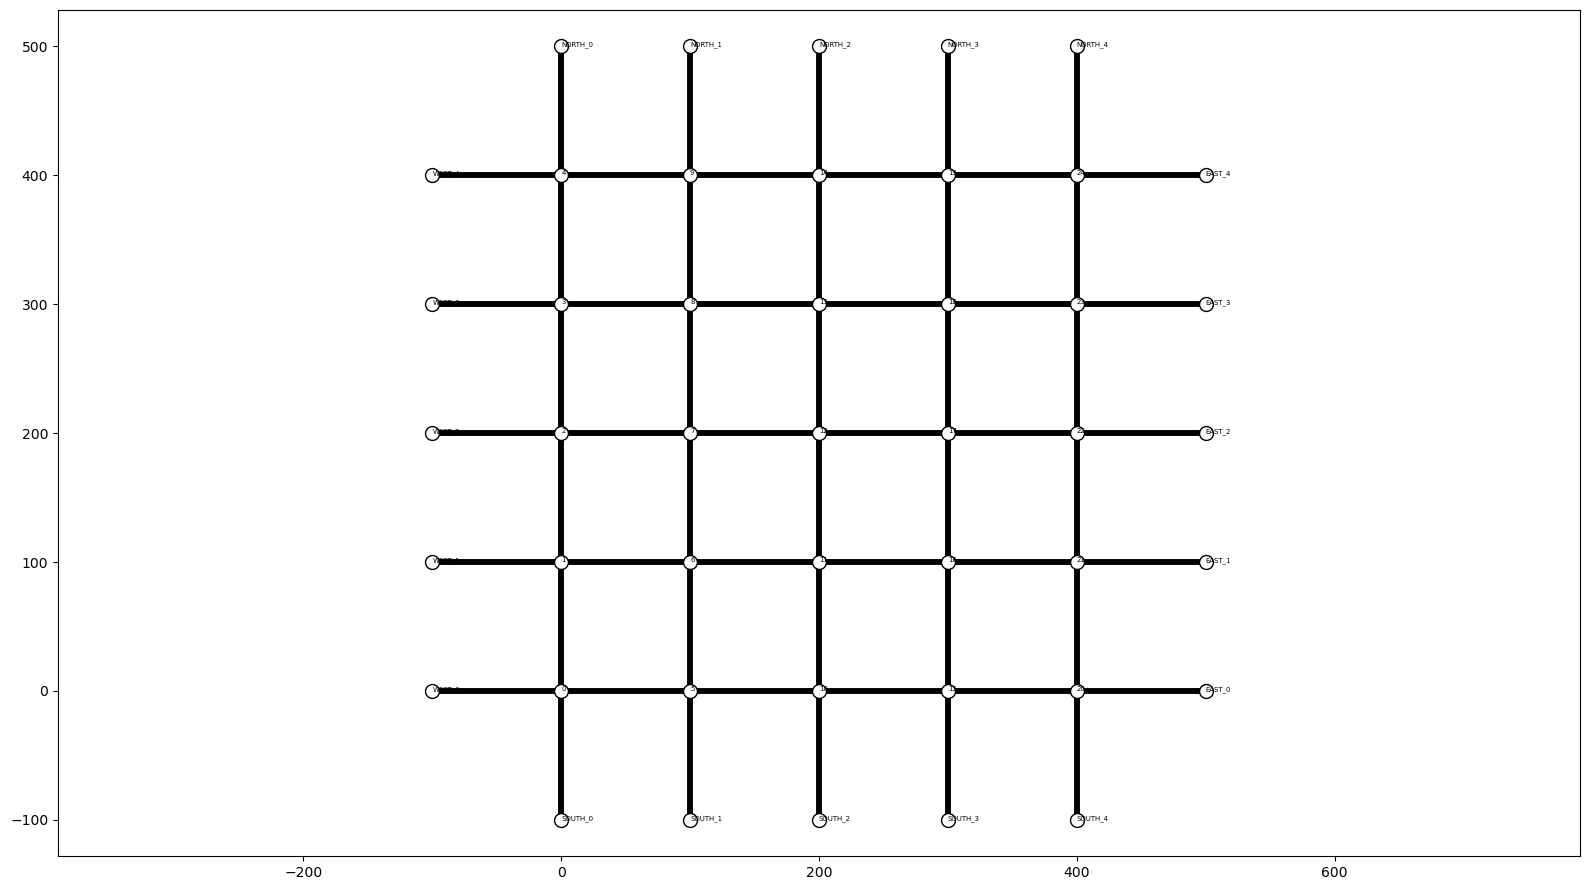

In [2]:
from mnms.tools.render import draw_roads

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, roads, linkwidth=4, nodesize=10)

## 2. The Mobility Services

### Add a "Personal CAR" Mobility Service

The name of the "Personal CAR" Mobility Service will be **'C0'**.

In [3]:
from mnms.generation.layers import generate_layer_from_roads
from mnms.mobility_service.personal_vehicle import PersonalMobilityService

car_service = PersonalMobilityService('C0')

### Add a "UBER" Mobility Service

The name of the "UBER" Mobility Service will be **'UBER0'**.

In [4]:
from mnms.mobility_service.on_demand import OnDemandMobilityService, OnDemandDepotMobilityService
uber_service = OnDemandDepotMobilityService("UBER0", 0)

### Create the "CAR" Layer

The **'CAR'** Layer will contain both "C0" and "UBER0" mobility services.

In [5]:
from mnms.graph.layers import CarLayer

# car_layer contains both car_service and uber_service
car_layer = generate_layer_from_roads(roads, "CAR", mobility_services=[car_service, uber_service])

### Add a "BUS" Mobility Service

The name of the "BUS" Mobility Service will be **'B0'**.

In [6]:
from mnms.mobility_service.public_transport import PublicTransportMobilityService

# register_stop(sid, lid, relative_position)
# sid: id of the stop created you want to give
# lid: id of the link where the stop should be
# relative_position: position on the link, should be between 0 and 1

# West to East bus stops
roads.register_stop('S_WE_0', 'WEST_2_2', 0.5)
roads.register_stop('S_WE_1', '2_7', 0.5)
roads.register_stop('S_WE_2', '7_12', 0.5)
roads.register_stop('S_WE_3', '12_17', 0.5)
roads.register_stop('S_WE_4', '17_22', 0.5)
roads.register_stop('S_WE_5', '22_EAST_2', 0.5)

# North to South bus stops
roads.register_stop('S_NS_0', 'NORTH_2_14', 0.5)
roads.register_stop('S_NS_1', '14_13', 0.5)
roads.register_stop('S_NS_2', '13_12', 0.5)
roads.register_stop('S_NS_3', '12_11', 0.5)
roads.register_stop('S_NS_4', '11_10', 0.5)
roads.register_stop('S_NS_5', '10_SOUTH_2', 0.5)

bus_service = PublicTransportMobilityService('B0')


### Create the "BUS" Layer

The **'BUS'** Layer will contain the "B0" mobility service.


In [7]:
from mnms.graph.layers import PublicTransportLayer
from mnms.vehicles.veh_type import Bus
from mnms.time import TimeTable, Dt

# default_speed: 30
bus_layer = PublicTransportLayer(roads, 'BUS', Bus, 30, services=[bus_service])

# create_line(lid, stops, sections, timetable)
# lid: id of the line created you want to give
# stops: list containing the stops of the line
# sections: list containing sublists where each sublist contains two links, the list is used to connect the stops
#           between them. Please see example below.
# timetable: timetable of the line

# create_table_freq(start, stop, dt)
# start: start time (first departure)
# end: end time (last departure)
# dt: frequency, unit (minutes/seconds) can be specified

# Central bus line West to East
bus_layer.create_line('L_WE',
                    ['S_WE_0', 'S_WE_1', 'S_WE_2', 'S_WE_3', 'S_WE_4', 'S_WE_5'],
                    [['WEST_2_2', '2_7'], ['2_7','7_12'], ['7_12', '12_17'], ['12_17', '17_22'], ['17_22', '22_EAST_2']],
                    TimeTable.create_table_freq('08:00:00', '12:00:00', Dt(minutes=1)))

# Central bus line North to South
bus_layer.create_line('L_NS',
                    ['S_NS_0', 'S_NS_1', 'S_NS_2', 'S_NS_3', 'S_NS_4', 'S_NS_5'],
                    [['NORTH_2_14', '14_13'], ['14_13', '13_12'], ['13_12', '12_11'], ['12_11', '11_10'], ['11_10', '10_SOUTH_2']],
                    TimeTable.create_table_freq('08:00:00', '12:00:00', Dt(minutes=1)))

## 3. The Multilayer graph

### Create an OD Layer

In [8]:
from mnms.generation.layers import _generate_matching_origin_destination_layer

odlayer = _generate_matching_origin_destination_layer(roads)

### Create a Multi Layer Graph

The **"Transit Link"** is used to connect a layer to another one.

In [9]:
from mnms.graph.layers import MultiLayerGraph

# MultiLayerGraph(layers, odlayer, connection_distance)
mlgraph = MultiLayerGraph([car_layer, bus_layer], odlayer, 1e-5)

# connect_layers(lid, upstream, downstream, length, costs)
# lid: id of the layer connection (or transit link) created you want to give
# upstream: id of node from upstream layer
# downstream: id of node from downstream layer
# length: length of the transit link
# costs: dict with the costs of the transit link

mlgraph.connect_layers("TL1", "CAR_WEST_2", "L_WE_S_WE_0", 5, {})
mlgraph.connect_layers("TL2", "CAR_2", "L_WE_S_WE_0", 5, {})

mlgraph.connect_layers("TL3", "CAR_22", "L_WE_S_WE_5", 5, {})
mlgraph.connect_layers("TL4", "CAR_EAST_2", "L_WE_S_WE_5", 5, {})

mlgraph.connect_layers("TL5", "CAR_NORTH_2", "L_NS_S_NS_0", 5, {})
mlgraph.connect_layers("TL6", "CAR_14", "L_NS_S_NS_0", 5, {})

mlgraph.connect_layers("TL7", "CAR_10", "L_NS_S_NS_5", 5, {})
mlgraph.connect_layers("TL8", "CAR_SOUTH_2", "L_NS_S_NS_5", 5, {})

mlgraph.connect_layers("TL9", "CAR_12", "L_WE_S_WE_2", 5, {})
mlgraph.connect_layers("TL10", "CAR_12", "L_WE_S_WE_3", 5, {})
mlgraph.connect_layers("TL11", "CAR_12", "L_NS_S_NS_2", 5, {})
mlgraph.connect_layers("TL12", "CAR_12", "L_NS_S_NS_3", 5, {})

### Display the Bus Lines

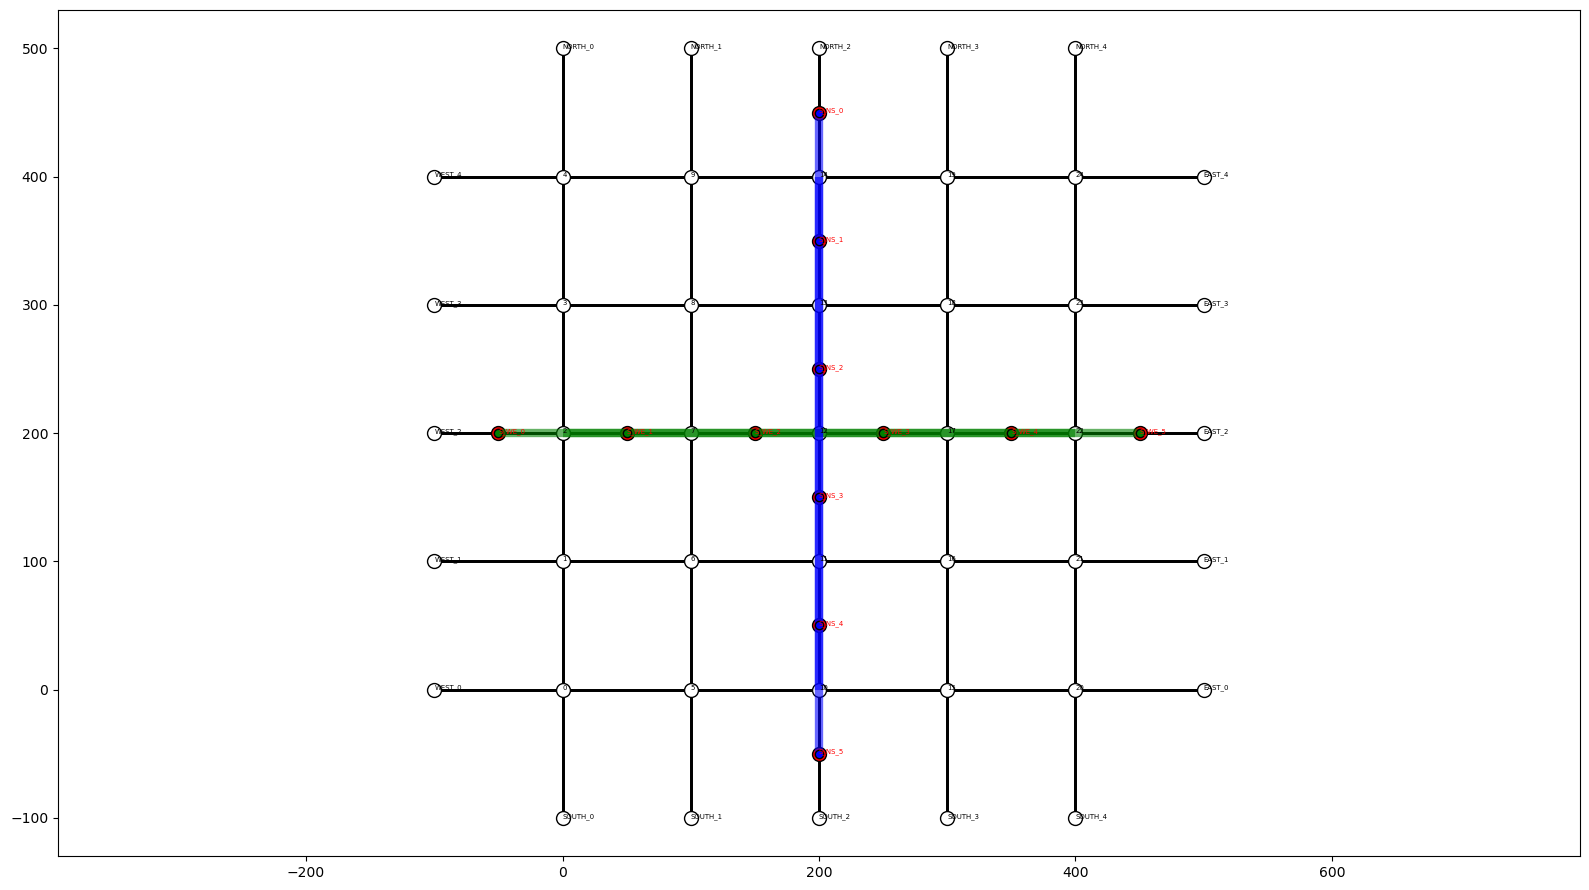

In [10]:
from mnms.tools.render import draw_line, draw_odlayer

fig, ax = plt.subplots(figsize=(16, 9))
draw_roads(ax, roads, linkwidth=2, nodesize=10)
draw_line(ax, mlgraph, bus_layer.lines["L_WE"], color='green')
draw_line(ax, mlgraph, bus_layer.lines["L_NS"], color='blue')

### Add a Uber Depot

The Uber depot will be created at the node "CAR_12" of the network and will have a capacity of 2 Uber cars.

In [11]:
uber_service.add_depot("CAR_12", capacity=2)

## 4. The Users

### Generate a Demand

The demand will have 10 users from 9:00 to 11:00.

In [12]:
from mnms.generation.demand import generate_random_demand

demand = generate_random_demand(mlgraph,
                                9,
                                tstart="9:00:00", 
                                tend="11:00:00", 
                                min_cost=0.4)

demand.show_users()

User('0', ORIGIN_18->DESTINATION_NORTH_4, 09:45:11.52)
User('1', ORIGIN_10->DESTINATION_20, 10:00:54.09)
User('2', ORIGIN_SOUTH_3->DESTINATION_WEST_1, 10:05:43.08)
User('3', ORIGIN_WEST_2->DESTINATION_11, 10:21:15.78)
User('4', ORIGIN_11->DESTINATION_S_NS_3, 10:27:40.32)
User('5', ORIGIN_5->DESTINATION_EAST_4, 10:29:39.95)
User('6', ORIGIN_22->DESTINATION_S_WE_1, 10:30:55.79)
User('7', ORIGIN_20->DESTINATION_15, 10:45:04.57)
User('8', ORIGIN_EAST_1->DESTINATION_EAST_2, 10:49:04.76)
User('9', ORIGIN_9->DESTINATION_2, 10:53:28.9)


### Load the Demand in MnMS

In [13]:
from mnms.time import Time

users = demand.get_next_departures(Time("09:00:00"), Time("11:00:00"))

### Create a Decision Model

The costs of the computed paths will be based on **travel time**.

In [14]:
from mnms.travel_decision import LogitDecisionModel

travel_decision = LogitDecisionModel(mlgraph,
                                     cost="travel_time",
                                     theta=0.01,
                                     n_shortest_path=3, outfile="path.csv")

### Compute the Paths

In [15]:
for user in users:
    travel_decision([user], user.departure_time)

for user in users:
    print(f"{user}, services:\n {user.path.mobility_services}")

User('0', ORIGIN_18->DESTINATION_NORTH_4, 09:45:11.52), services:
 ['C0']
User('1', ORIGIN_10->DESTINATION_20, 10:00:54.09), services:
 ['C0']
User('2', ORIGIN_SOUTH_3->DESTINATION_WEST_1, 10:05:43.08), services:
 ['C0']
User('3', ORIGIN_WEST_2->DESTINATION_11, 10:21:15.78), services:
 ['C0']
User('4', ORIGIN_11->DESTINATION_S_NS_3, 10:27:40.32), services:
 ['C0', 'B0']
User('5', ORIGIN_5->DESTINATION_EAST_4, 10:29:39.95), services:
 ['C0']
User('6', ORIGIN_22->DESTINATION_S_WE_1, 10:30:55.79), services:
 ['C0', 'B0']
User('7', ORIGIN_20->DESTINATION_15, 10:45:04.57), services:
 ['C0']
User('8', ORIGIN_EAST_1->DESTINATION_EAST_2, 10:49:04.76), services:
 ['C0']
User('9', ORIGIN_9->DESTINATION_2, 10:53:28.9), services:
 ['C0']


### Display some Paths

We want to display the paths of users who have taken the bus.

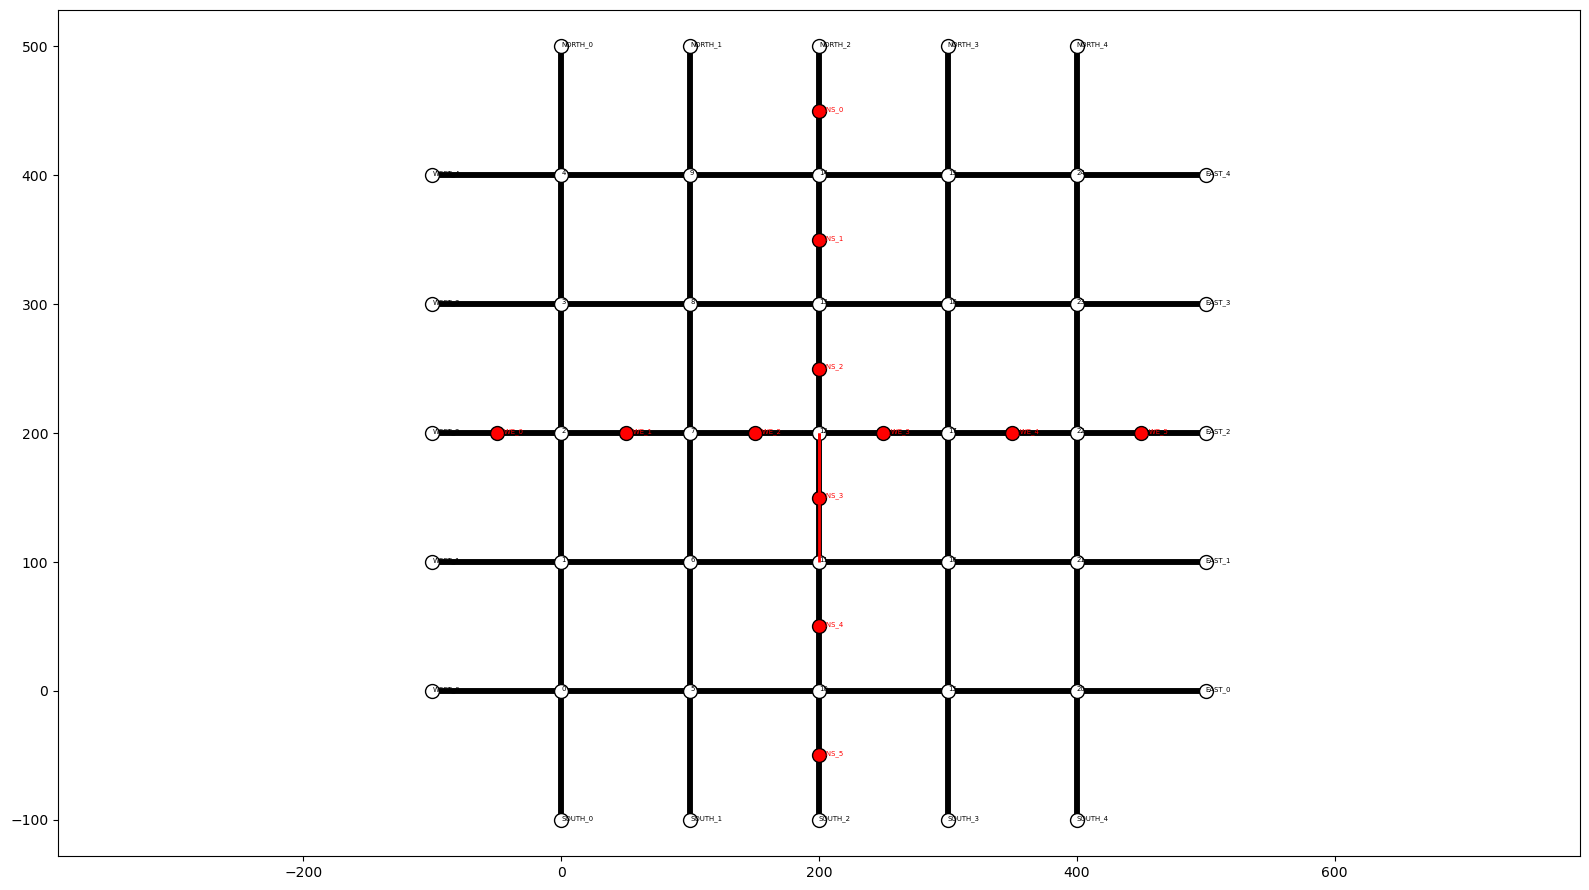

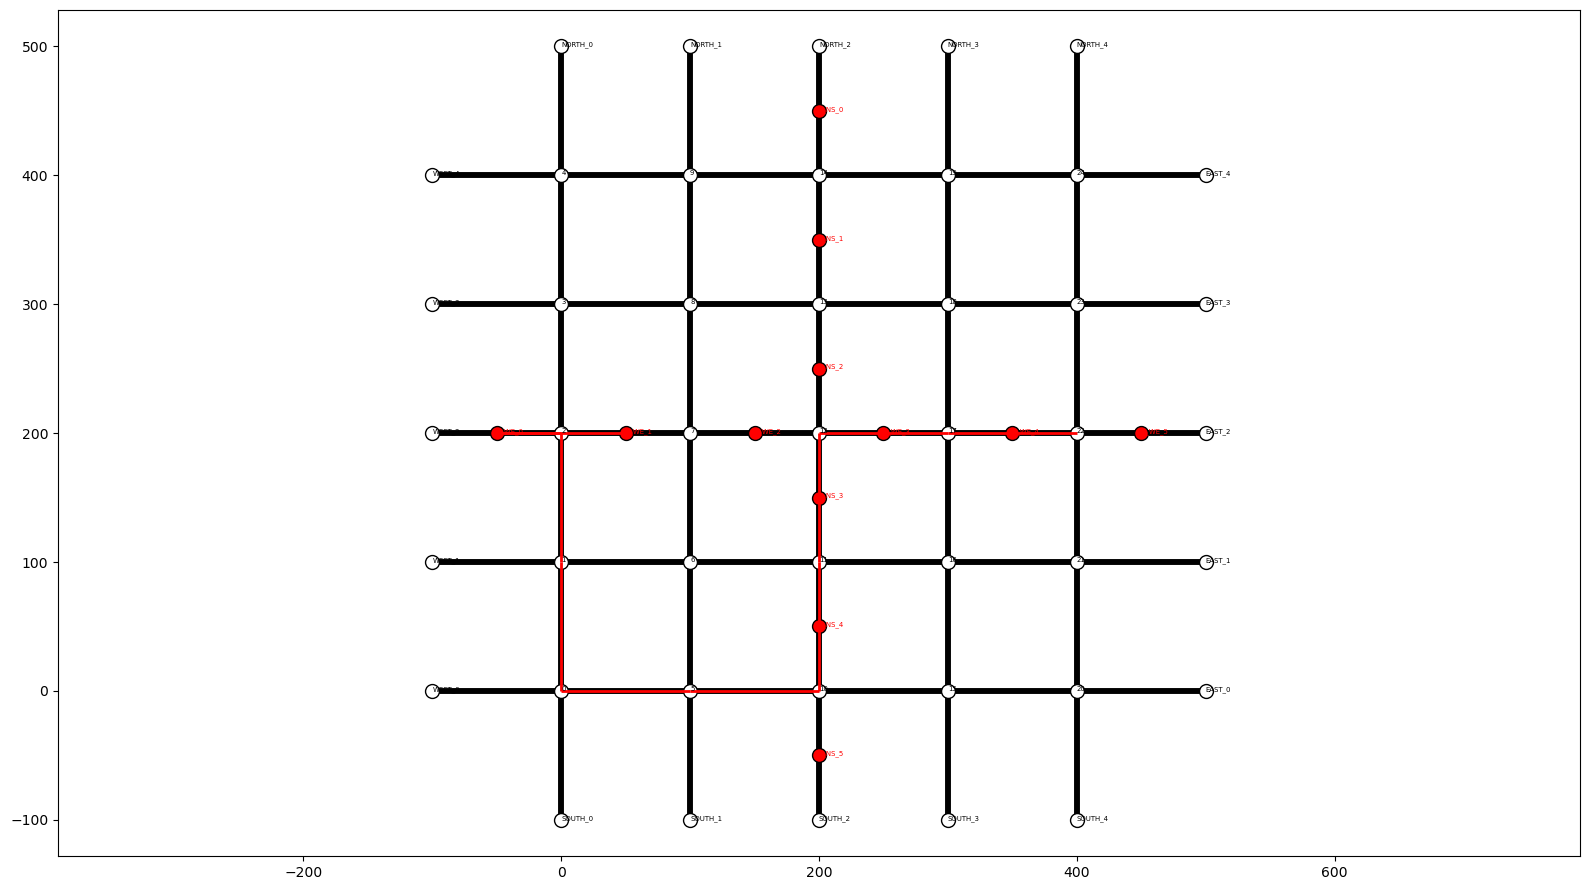

In [16]:
from mnms.tools.render import draw_path

for user in users:
    if len(user.path.mobility_services) > 1:
        fig, ax = plt.subplots(figsize=(16, 9))
        draw_roads(ax, mlgraph.roads, linkwidth=4, nodesize=10)
        draw_path(ax, mlgraph, user.path)

## 5. The Simulation

### Create a MFD (Macroscopic Fundamental Diagram) Function

The MFD Function will define the speed for each transport layer :
1. The speed of **Bus** mobility service is fixed at 30m/s
2. The speed of **Personal Car** and **Uber** mobility services will depend on traffic (accumulation)

In [17]:
def v_MFD(acc):
    V = 0
    N = acc["CAR"]
    
    if N < 10:
        V = 14
    elif N < 20:
        V = 12
    elif N < 50:
        V = 10
    else:
        V = 5
        
    V_BUS = 30
    return {"CAR": V, "BUS": V_BUS}

### Add a Flow Motor

The network will have only one **Reservoir**.

In [18]:
from mnms.flow.MFD import Reservoir, MFDFlowMotor

flow_motor = MFDFlowMotor()
res = Reservoir(mlgraph.roads.zones["RES"], ["CAR", "BUS"], v_MFD)
flow_motor.add_reservoir(res)

### Create a Supervisor

The supervisor contains the Multi-Layer Graph, the Demand, the Flow Motor and the Decision Model.

In [19]:
from mnms.simulation import Supervisor

supervisor = Supervisor(mlgraph,
                        demand,
                        flow_motor,
                        travel_decision,
                        outfile="travel_time_link.csv")

### Run the Simulation

The MnMS Simulation will run from 9:00 to 12:00.

In [20]:
supervisor.run(Time("09:00:00"),
               Time("12:00:00"),
               Dt(minutes=1),
               1)

Run |■■■■■■■■■■■■■■■■■■■■| 100 % | remain ~ 0 s
